In [1]:
%run lib.py

# load text

In [2]:
import text_util

In [3]:
pap = pd.read_csv('papers_parsed_relevant.csv',index_col=0)

In [ ]:
pap.head().T

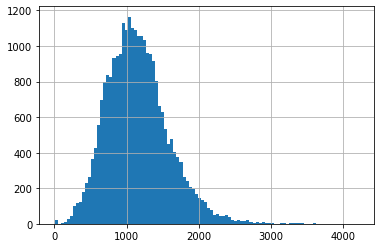

In [5]:
pap['abstract'].apply(str).apply(len).hist(bins=100);

In [10]:
pap['abstract'] = pap['abstract'].str.replace(r'^Abstract', '')
texts_orig = (pap['title'] + ' ' + pap['abstract'])
texts_orig = texts_orig[texts_orig.apply(str).apply(len) > 100]

In [11]:
tqdm.pandas()

In [35]:
texts = texts_orig.progress_apply(reload(text_util).preprocess_text)

100%|██████████| 26799/26799 [09:23<00:00, 47.55it/s]


In [36]:
texts.to_frame().to_csv('texts_preproc_relevant.csv')

---

In [6]:
texts = pd.read_csv('texts_preproc_relevant.csv', index_col=0).iloc[:, 0]

In [7]:
texts.shape

(26799,)

---

In [15]:
%%writefile build_ast.py
import east

def build_ast(data):
    i, text = data
    return i, east.asts.base.AST.get_ast(east.utils.text_to_strings_collection(text, words=5))

Writing build_ast.py


In [8]:
from tqdm import tqdm_notebook as tqdm
import build_ast

In [13]:
BUFF_SIZE = 5000
with shelve.open('asts_relevant') as asts:
    
    keys = max([int(i)+1 for i in asts] + [0])
    total = len([i for i, _ in texts.iteritems() if i >= keys])
    
    it = ((i, text) for i, text in texts.iteritems() if i >= keys)
    executor = execute(reload(build_ast).build_ast, it, n_jobs=120)
    
    buffer = []
    
    max_i = 0
    
    for i, ast in tqdm(executor, total=total):

        buffer.append((str(i), ast))
        max_i = max(max_i, i)
        if len(buffer) == BUFF_SIZE:
            asts[str(max_i)] = buffer
            buffer = []
            
    if len(buffer) > 0:
        asts[str(max_i)] = buffer
                
        

In [14]:
with shelve.open('asts_relevant') as asts:
    for k in asts:
        print(k)
    print( sum([len(asts[k]) for k in asts.keys()]))
    

11887
23071
37016
50273
63793
68931
26799


In [15]:
with shelve.open('asts_relevant') as asts:
    print(asts['11887'][0][1].strings_collection)

['CLUSTERCLUSTERANALYSISCLUSTERABILITYMETHODS', 'CLUSTERINGESSENTIALDATAMININGTOOL', 'AIMSDISCOVERINHERENTCLUSTERSTRUCTURE', 'DATAAPPLICATIONSAPPLYINGCLUSTERINGAPPROPRIATE', 'CLUSTERSTRUCTUREPRESENTSTUDYCLUSTERABILITY', 'EVALUATESWHETHERDATAPOSSESSESSTRUCTURE', 'INTEGRALPARTCLUSTERANALYSISHOWEVER', 'METHODSEVALUATINGCLUSTERABILITYVARYRADICALLY', 'MAKINGCHALLENGINGSELECTSUITABLEMEASURE', 'PAPERPERFORMEXTENSIVECOMPARISONMEASURES', 'CLUSTERABILITYPROVIDEGUIDELINESCLUSTERINGUSERS', 'REFERENCESELECTSUITABLEMEASURESAPPLICATIONS']


## score keywords

In [18]:
ds_tax = pd.read_csv('data/ds_taxonomy_parsed_full.csv')

topics = ds_tax['label'].values
leaf_topics = topics[ds_tax['isleaf']]

In [25]:
topics = [east.utils.prepare_text(text_util.preprocess_text(t)).replace(' ', '') for t in leaf_topics]

In [26]:
len(topics)

353

In [27]:
print(topics)

['SAMPLECOMPLEXITYGENERALIZATIONBOUNDS', 'BOOLEANFUNCTIONLEARNING', 'UNSUPERVISEDLEARNINGCLUSTERING', 'SUPPORTVECTORMACHINES', 'GAUSSIANPROCESSES', 'MODELLING', 'BOOSTING', 'BAYESIANANALYSIS', 'INDUCTIVEINFERENCE', 'ONLINELEARNINGTHEORY', 'MULTIAGENTLEARNING', 'MODELSLEARNING', 'QUERYLEARNING', 'STRUCTUREDPREDICTION', 'SEQUENTIALDECISIONMAKING', 'INVERSEREINFORCEMENTLEARNING', 'APPRENTICESHIPLEARNING', 'MULTIAGENTREINFORCEMENTLEARNING', 'ADVERSARIALLEARNING', 'ACTIVELEARNING', 'SEMISUPERVISEDLEARNING', 'MARKOVDECISIONPROCESSES', 'REGRETBOUNDS', 'DATAEXCHANGE', 'DATAPROVENANCE', 'DATAMODELING', 'DATABASEQUERYLANGUAGESPRINCIPLES', 'DATABASECONSTRAINTSTHEORY', 'DATABASEINTEROPERABILITY', 'DATASTRUCTURESALGORITHMSDATAMANAGEMENT', 'DATABASEQUERYPROCESSINGOPTIMIZATIONTHEORY', 'DATAINTEGRATION', 'LOGICDATABASES', 'THEORYDATABASEPRIVACYSECURITY', 'INCOMPLETEINCONSISTENTUNCERTAINDATABASES', 'BAYESIANNETWORKS', 'MARKOVNETWORKS', 'FACTORGRAPHS', 'DECISIONDIAGRAMS', 'EQUATIONALMODELS', 'CAUSALNETW

In [28]:
%%writefile score_ast.py
topics = ['SAMPLECOMPLEXITYGENERALIZATIONBOUNDS', 'BOOLEANFUNCTIONLEARNING', 'UNSUPERVISEDLEARNINGCLUSTERING', 'SUPPORTVECTORMACHINES', 'GAUSSIANPROCESSES', 'MODELLING', 'BOOSTING', 'BAYESIANANALYSIS', 'INDUCTIVEINFERENCE', 'ONLINELEARNINGTHEORY', 'MULTIAGENTLEARNING', 'MODELSLEARNING', 'QUERYLEARNING', 'STRUCTUREDPREDICTION', 'SEQUENTIALDECISIONMAKING', 'INVERSEREINFORCEMENTLEARNING', 'APPRENTICESHIPLEARNING', 'MULTIAGENTREINFORCEMENTLEARNING', 'ADVERSARIALLEARNING', 'ACTIVELEARNING', 'SEMISUPERVISEDLEARNING', 'MARKOVDECISIONPROCESSES', 'REGRETBOUNDS', 'DATAEXCHANGE', 'DATAPROVENANCE', 'DATAMODELING', 'DATABASEQUERYLANGUAGESPRINCIPLES', 'DATABASECONSTRAINTSTHEORY', 'DATABASEINTEROPERABILITY', 'DATASTRUCTURESALGORITHMSDATAMANAGEMENT', 'DATABASEQUERYPROCESSINGOPTIMIZATIONTHEORY', 'DATAINTEGRATION', 'LOGICDATABASES', 'THEORYDATABASEPRIVACYSECURITY', 'INCOMPLETEINCONSISTENTUNCERTAINDATABASES', 'BAYESIANNETWORKS', 'MARKOVNETWORKS', 'FACTORGRAPHS', 'DECISIONDIAGRAMS', 'EQUATIONALMODELS', 'CAUSALNETWORKS', 'STOCHASTICDIFFERENTIALEQUATIONS', 'KERNELDENSITYESTIMATORS', 'SPLINEMODELS', 'BAYESIANNONPARAMETRICMODELS', 'MAXIMUMLIKELIHOODESTIMATION', 'BAYESIANCOMPUTATION', 'COMPUTINGPROBABLEEXPLANATION', 'HYPOTHESISTESTINGCONFIDENCEINTERVALCOMPUTATION', 'QUANTILEREGRESSION', 'MAXMARGINALCOMPUTATION', 'VARIABLEELIMINATION', 'LOOPYBELIEFPROPAGATION', 'VARIATIONALMETHODS', 'EXPECTATIONMAXIMIZATION', 'GIBBSSAMPLING', 'METROPOLISHASTINGSALGORITHM', 'SIMULATEDANNEALING', 'MARKOVCHAINMONTECARLOCONVERGENCEMEASURES', 'SEQUENTIALMONTECARLOMETHODS', 'FACTORIALHMM', 'BOOTSTRAPPING', 'JACKKNIFING', 'RANDOMNUMBERGENERATION', 'PROBABILISTICALGORITHMS', 'QUEUEINGTHEORY', 'CONTINGENCYTABLEANALYSIS', 'ROBUSTREGRESSION', 'TIMESERIESANALYSIS', 'SURVIVALANALYSIS', 'RENEWALTHEORY', 'DIMENSIONALITYREDUCTION', 'CLUSTERANALYSIS', 'STATISTICALGRAPHICS', 'EXPLORATORYDATAANALYSIS', 'MARKOVPROCESSES', 'NONPARAMETRICSTATISTICS', 'DISTRIBUTIONFUNCTIONS', 'MULTIVARIATESTATISTICS', 'RELATIONALDATABASEMODEL', 'ENTITYRELATIONSHIPMODELS', 'HIERARCHICALDATAMODELS', 'NETWORKDATAMODELS', 'PHYSICALDATAMODELS', 'SEMISTRUCTUREDDATA', 'DATASTREAMS', 'DATAPROVENANCE', 'INCOMPLETEDATA', 'TEMPORALDATA', 'UNCERTAINTY', 'INCONSISTENTDATA', 'MULTIDIMENSIONALRANGESEARCH', 'DATASCANS', 'POINTLOOKUPS', 'UNIDIMENSIONALRANGESEARCH', 'PROXIMITYSEARCH', 'DATACOMPRESSION', 'DATAENCRYPTION', 'RECORDBLOCKLAYOUT', 'DBMSENGINEARCHITECTURES', 'QUERYOPTIMIZATION', 'QUERYOPERATORS', 'QUERYPLANNING', 'JOINALGORITHMS', 'DATALOCKING', 'TRANSACTIONLOGGING', 'DATABASERECOVERY', 'RECORDBUFFERMANAGEMENT', 'KEYVALUESTORES', 'MAPREDUCEBASEDSYSTEMS', 'RELATIONALPARALLELDISTRIBUTEDDBMSS', 'TRIGGERSRULES', 'DATABASEVIEWS', 'INTEGRITYCHECKING', 'DISTRIBUTEDDATALOCKING', 'DEADLOCKS', 'DISTRIBUTEDDATABASERECOVERY', 'MAINMEMORYENGINES', 'ONLINEANALYTICALPROCESSINGENGINES', 'STREAMMANAGEMENT', 'STRUCTUREDQUERYLANGUAGE', 'XPATH', 'XQUERY', 'MAPREDUCELANGUAGES', 'CALLLEVELINTERFACES', 'DEDUPLICATION', 'EXTRACTIONTRANSFORMATIONLOADING', 'DATAEXCHANGE', 'DATACLEANING', 'WRAPPERSDATAMINING', 'MEDIATORSDATAINTEGRATION', 'ENTITYRESOLUTION', 'DATAWAREHOUSES', 'FEDERATEDDATABASES', 'DATACLEANING', 'ITEMBASED', 'SCALABLE', 'TYPESASSOCIATIONRULES', 'INTERESTINGNESS', 'PARALLELCOMPUTATION', 'MASSIVEDATACLUSTERING', 'CONSENSUSCLUSTERING', 'FUZZYCLUSTERING', 'ADDITIVECLUSTERING', 'FEATUREWEIGHTCLUSTERING', 'CONCEPTUALCLUSTERING', 'BICLUSTERING', 'NEARESTNEIGHBORSEARCH', 'DATASTREAMMINING', 'GRAPHPARTITIONING', 'FREQUENTGRAPHMINING', 'GRAPHBASEDCONCEPTUALCLUSTERING', 'ANOMALYDETECTION', 'CRITICALNODESDETECTION', 'PROCESSMINING', 'TEXTCATEGORIZATION', 'KEYPHRASEINDEXING', 'DATAMININGTOOLS', 'RULEPATTERNDISCOVERY', 'TRAJECTORYCLUSTERING', 'MARKETGRAPH', 'FORMALCONCEPTANALYSIS', 'SITEWRAPPING', 'DEEPWEB', 'SURFACING', 'SEARCHRESULTSDEDUPLICATION', 'WEBLOGANALYSIS', 'TRAFFICANALYSIS', 'KNOWLEDGEDISCOVERY', 'DOCUMENTSTRUCTURE', 'DOCUMENTTOPICMODELS', 'CONTENTANALYSISFEATURESELECTION', 'DATAENCODINGCANONICALIZATION', 'DOCUMENTCOLLECTIONMODELS', 'ONTOLOGIES', 'DICTIONARIES', 'THESAURI', 'QUERYREPRESENTATION', 'QUERYINTENT', 'QUERYLOGANALYSIS', 'QUERYSUGGESTION', 'QUERYREFORMULATION', 'PERSONALIZATION', 'TASKMODELS', 'SEARCHINTERFACES', 'COLLABORATIVESEARCH', 'RANKAGGREGATION', 'PROBABILISTICRETRIEVALMODELS', 'LANGUAGEMODELS', 'SIMILARITYMEASURES', 'LEARNINGRANK', 'COMBINATIONFUSIONFEDERATEDSEARCH', 'INFORMATIONRETRIEVALDIVERSITY', 'TOPKRETRIEVALDATABASES', 'NOVELTYINFORMATIONRETRIEVAL', 'QUESTIONANSWERING', 'DOCUMENTFILTERING', 'RECOMMENDERSYSTEMS', 'INFORMATIONEXTRACTION', 'SENTIMENTANALYSIS', 'EXPERTSEARCH', 'NEARDUPLICATEPLAGIARISMDETECTION', 'CLUSTERINGCLASSIFICATION', 'SUMMARIZATION', 'BUSINESSINTELLIGENCE', 'TESTCOLLECTIONS', 'RELEVANCEASSESSMENT', 'RETRIEVALEFFECTIVENESS', 'RETRIEVALEFFICIENCY', 'PRESENTATIONRETRIEVALRESULTS', 'STRUCTUREDTEXTSEARCH', 'MATHEMATICSRETRIEVAL', 'CHEMICALBIOCHEMICALRETRIEVAL', 'MULTILINGUALCROSSLINGUALRETRIEVAL', 'IMAGESEARCH', 'VIDEOSEARCH', 'SPEECHAUDIOSEARCH', 'MUSICRETRIEVAL', 'ENTERPRISESEARCH', 'DESKTOPSEARCH', 'WEBSOCIALMEDIASEARCH', 'TREEMAPS', 'HYPERBOLICTREES', 'HEATMAPS', 'GRAPHDRAWINGS', 'DENDROGRAMS', 'CLADOGRAMS', 'ELASTICMAPS', 'SCIENTIFICVISUALIZATION', 'VISUALANALYTICS', 'GEOGRAPHICVISUALIZATION', 'INFORMATIONVISUALIZATION', 'VISUALIZATIONTOOLKITS', 'VISUALIZATIONTHEORYCONCEPTSPARADIGMS', 'EMPIRICALSTUDIESVISUALIZATION', 'VISUALIZATIONDESIGNEVALUATIONMETHODS', 'INFORMATIONEXTRACTION', 'MACHINETRANSLATION', 'DISCOURSEDIALOGUEPRAGMATICS', 'NATURALLANGUAGEGENERATION', 'SPEECHRECOGNITION', 'WIKIPEDIABASEDSEMANTICS', 'PHONOLOGYMORPHOLOGY', 'LANGUAGERESOURCES', 'DESCRIPTIONLOGICS', 'SEMANTICNETWORKS', 'NONMONOTONICDEFAULTREASONINGBELIEFREVISION', 'PROBABILISTICREASONING', 'VAGUENESSFUZZYLOGIC', 'CAUSALREASONINGDIAGNOSTICS', 'TEMPORALREASONING', 'COGNITIVEROBOTICS', 'ONTOLOGYENGINEERING', 'LOGICPROGRAMMINGANSWERSETPROGRAMMING', 'SPATIALPHYSICALREASONING', 'REASONINGBELIEFKNOWLEDGE', 'INTERESTPOINTSALIENTREGIONDETECTIONS', 'IMAGESEGMENTATION', 'VIDEOSEGMENTATION', 'SHAPEINFERENCE', 'OBJECTDETECTION', 'OBJECTRECOGNITION', 'OBJECTIDENTIFICATION', 'TRACKING', 'RECONSTRUCTION', 'MATCHING', '2DPCA', 'SHAPEREPRESENTATIONS', 'APPEARANCETEXTUREREPRESENTATIONS', 'HIERARCHICALREPRESENTATIONS', 'RANKING', 'LEARNINGRANK', 'SUPERVISEDLEARNINGCLASSIFICATION', 'SUPERVISEDLEARNINGREGRESSION', 'STRUCTUREDOUTPUTS', 'COSTSENSITIVELEARNING', 'CLUSTERANALYSIS', 'ANOMALYDETECTION', 'MIXTUREMODELING', 'TOPICMODELING', 'SOURCESEPARATION', 'MOTIFDISCOVERY', 'GRAPHEMBEDDING', 'SUPERVISEDDIMESIONALITYREDUCTION', 'SEQUENTIALDECISIONMAKING', 'INVERSEREINFORCEMENTLEARNING', 'APPRENTICESHIPLEARNING', 'MULTIAGENTREINFORCEMENTLEARNING', 'ADVERSARIALLEARNING', 'TRANSFERLEARNING', 'LIFELONGMACHINELEARNING', 'LEARNINGCOVARIATESHIFT', 'BATCHLEARNING', 'ONLINELEARNINGSETTINGS', 'LEARNINGDEMONSTRATIONS', 'LEARNINGCRITIQUES', 'LEARNINGIMPLICITFEEDBACK', 'ACTIVELEARNINGSETTINGS', 'KERNELAPPROACH', 'PARALLELIMPLEMENTATION', 'SPLITTTINGCRITERIA', 'MODELTREES', 'DYNAMIC', 'GAUSSIANPROCESSES', 'KERNELMATRIX', 'KERNELINDEPENDENTCOMPONENTS', 'KERNELBASEDCLUSTERING', 'SELFORGANIZEDMAP', 'EVOLUTIONARYAPPROACH', 'RULEBASEDNETWOKARCHIRTECTURE', 'FUZZYREPRESENTATION', 'EVOLVINGNN', 'ENSEMBLING', 'INDUCTIVELOGICLEARNING', 'STATISTICALRELATIONALLEARNING', 'MAXIMUMLIKELIHOODMODELING', 'MAXIMUMENTROPYMODELING', 'MAXIMUMPOSTERIORIMODELING', 'MIXTUREMODELS', 'LATENTVARIABLEMODELS', 'BAYESIANNETWORKMODELS', 'MARKOVNETWORKMODELS', 'PERCEPTRONALGORITHM', 'TENSORREPRESENTATION', 'NONNEGATIVEMATRIXFACTORIZATION', 'FACTORANALYSIS', '2DPCA', 'SPARSEPCA', 'CANONICALCORRELATIONANALYSIS', 'LATENTDIRICHLETALLOCATION', 'INDEPENDENTCOMPONENTANALYSIS', 'NONLINEARPRINCIPALCOMPONENTS', 'LEASTMODULI', 'NEUROFUZZYAPPROACH', 'INSTANCEBASEDLEARNING', 'MARKOVDECISIONPROCESSES', 'PARTIALLYOBSERVABLEMARKOVDECISIONPROCESSES', 'STOCHASTICGAMES', 'DEEPBELIEFNETWORKS', 'MULTIRESOLUTION', 'SUPPORTVECTORMACHINES', 'VALUEITERATION', 'QLEARNING', 'POLICYITERATION', 'TEMPORALDIFFERENCELEARNING', 'APPROXIMATEDYNAMICPROGRAMMINGMETHODS', 'BOOSTING', 'BAGGING', 'FUSIONCLASSIFIERS', 'SPECTRALCLUSTERING', 'FEATURESELECTION', 'GENERALIZEDEIGENVALUE', 'CROSSVALIDATION']

def score(data):
    i, ast = data
    return i, [ast.score(t) for t in topics]
    

Writing score_ast.py


In [29]:
from tqdm import tqdm_notebook as tqdm

In [33]:
import score_ast
reload(score_ast)

with shelve.open('asts_relevant') as asts,\
     shelve.open('asts_relevant_topic_scores') as topic_score_shelf,\
     tqdm(total=len(texts)) as pbar:
    
    for key in asts:
        scores = []
        it = ((i, ast) for i, ast in asts[key])
        executor = execute(score_ast.score, it, n_jobs=50)
        for result in tqdm(executor, total=len(asts[key])):
            scores.append(result)
            pbar.update()
            
        topic_score_shelf[key] = scores

---

Check EAST

In [133]:
import build_ast
import text_util
import east

In [134]:
txt = 'Clustering is an essential data mining tool that aims to discover inherent cluster structure in data. For most applications, applying clustering is only appropriate when cluster structure is present. As such, the study of clusterability, which evaluates whether data possesses such structure, is an integral part of cluster analysis. However, methods for evaluating clusterability vary radically, making it challenging to select a suitable measure. In this paper, we perform an extensive comparison of measures of clusterability and provide guidelines that clustering users can reference to select suitable measures for their applications.'
txt = text_util.preprocess_text( txt)

In [135]:
txt = east.utils.text_to_strings_collection(txt, words=5)
txt

['CLUSTERINGESSENTIALDATAMININGTOOL',
 'AIMSDISCOVERINHERENTCLUSTERSTRUCTURE',
 'DATAAPPLICATIONSAPPLYINGCLUSTERINGAPPROPRIATE',
 'CLUSTERSTRUCTUREPRESENTSTUDYCLUSTERABILITY',
 'EVALUATESWHETHERDATAPOSSESSESSTRUCTURE',
 'INTEGRALPARTCLUSTERANALYSISHOWEVER',
 'METHODSEVALUATINGCLUSTERABILITYVARYRADICALLY',
 'MAKINGCHALLENGINGSELECTSUITABLEMEASURE',
 'PAPERPERFORMEXTENSIVECOMPARISONMEASURES',
 'CLUSTERABILITYPROVIDEGUIDELINESCLUSTERINGUSERS',
 'REFERENCESELECTSUITABLEMEASURESAPPLICATIONS']

In [136]:
ast = east.asts.base.AST.get_ast(txt, 'easa')

In [137]:
ast.score(east.utils.prepare_text('fence'), return_suffix_scores=True)

(0.22918930784828406,
 {'FENCE': 0.25228310502283113,
  'ENCE': 0.35051670271569324,
  'NCE': 0.3652276186522762,
  'CE': 0.04778212654924974,
  'E': 0.13013698630136994})

In [138]:
ast.score(east.utils.prepare_text('SINCE'), return_suffix_scores=True)

(0.16615453541413477,
 {'SINCE': 0.072342571944356,
  'INCE': 0.21528337362342187,
  'NCE': 0.3652276186522762,
  'CE': 0.04778212654924974,
  'E': 0.13013698630136994})